## Librairies Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

We import the Picsellia Client to communicate with the platform and checkout the experiment using our credentials (API token) and the project token (that you can find in your project dashboard)

In [2]:
from picsellia.client import Client

api_token = ""
project_token = ""
experiment_name = ""
clt = Client.Experiment(api_token, project_token=project_token)
exp = clt.checkout(name=experiment_name, with_file=True)


Hi pierre-nicolas, welcome back.


# Download the dataset and split the classes into different folders

As we have attached an annotated dataset to our experiment, we will get the annotations, download the annotated images and perform a train/test split to separate our data between training and evaluation.
We then log() the data repartition so it is stored in your experiment dashboard on Picsellia.

In [3]:
exp.dl_annotations()
exp.dl_pictures()
exp.train_test_split()
train_split = {
    'x': exp.categories,
    'y': exp.train_repartition,
    'image_list': exp.train_list_id
}
exp.log('train-split', train_split, 'bar', replace=True)

test_split = {
    'x': exp.categories,
    'y': exp.test_repartition,
    'image_list': exp.eval_list_id
}
exp.log('test-split', test_split, 'bar', replace=True)



-----
[==================================================] 313/313--*--
Images downloaded
250 images used for training and 63 images used for validation


We create a labelmap from our Dataset and log it in the experiment dashboard

In [4]:
labels_index = [e for e in range(1, len(exp.categories)+1)]
labelmap = dict(zip(labels_index, exp.categories))
exp.log('labelmap', labelmap, 'labelmap', replace=True)


## We create all the directories from the image folder so we can create a dataset with Tensorflow utils easily

In [5]:
splits = ["train", "validation"]
for split in splits:
    if not split in os.listdir("images"):
        os.mkdir(f"images/{split}")
    for category in exp.categories:
        if not category in os.listdir(f"images/{split}"):
            os.mkdir(f"images/{split}/{category}")


## Now we will go through the list generated by the train_test_split() method and move the images to their corresponding directory

In [6]:
train_dir = "images/train"
validation_dir = "images/validation"

for train_img in exp.train_list:
    filename = train_img.split("/")[-1]
    label = filename.split("_")[0]
    os.rename(train_img, f"{train_dir}/{label}/{filename}")

for eval_img in exp.eval_list:
    filename = eval_img.split("/")[-1]
    label = filename.split("_")[0]
    os.rename(eval_img, f"{validation_dir}/{label}/{filename}")

Get the parameters defined when the experiment was created

In [7]:
parameters = exp.get_data("parameters")

Create the Training set

In [8]:
BATCH_SIZE = parameters["batch_size"]
IMG_SIZE = (parameters["image_size"], parameters["image_size"])

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 250 files belonging to 3 classes.


Create the validation set

In [9]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 63 files belonging to 3 classes.


Show the first nine images and labels from the training set:

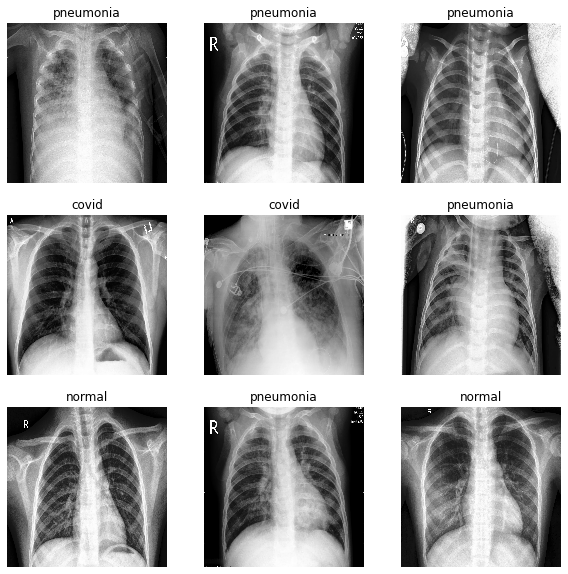

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 2
Number of test batches: 0


## Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. 

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


Let's repeatedly apply these layers to the same image and see the result.

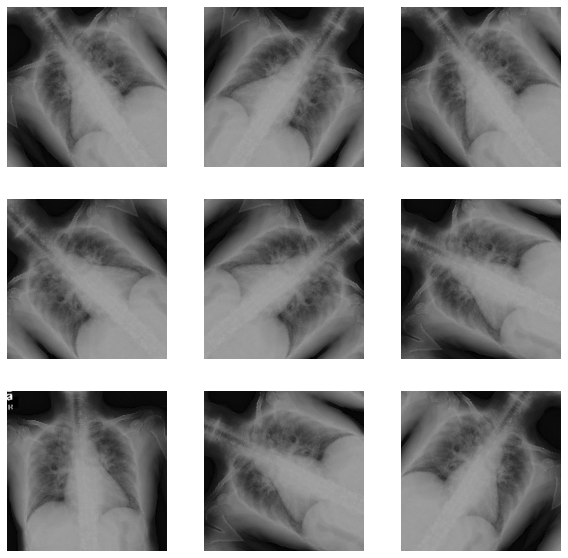

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


## Rescale Pixel values
The model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = IMG_SIZE + (3,)



## Define training callback

In [17]:
from tensorflow.keras.callbacks import Callback

class PicselliaLogger(Callback):

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            exp.log(log_name, [float(log_value)], 'line')

callback_list = [PicselliaLogger()]

In [18]:
fine_tune = parameters["fine_tune"]

# IF FINE_TUNE == FALSE (if it's the first time you train the model and the weights comes from the original model, not from a previous experiment where you have uploaded fine-tuned weights)

# Please see 13 cells below to train with fine-tuned weights

## Create the base model from the pre-trained model chosen in the experiment

You will create the base model from the MobileNet V2 model developed at Google.
First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [19]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=os.path.join(exp.base_dir, "model.h5"))


## Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [20]:
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [40]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [23]:
inputs = tf.keras.Input(shape=(parameters["image_size"], parameters["image_size"], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


### Compile the model

In [24]:


base_learning_rate = parameters["learning_rate"]
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [25]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

### Train the model

In [26]:
initial_epochs = parameters["initial_epochs"]

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=callback_list,
                    validation_data=validation_dataset)


2/2 [==============================] - 2s 252ms/step - loss: 9.7922e-08 - accuracy: 0.3790
initial loss: 0.00
initial accuracy: 0.38
Epoch 1/10
8/8 [==============================] - 8s 431ms/step - loss: 1.0300e-07 - accuracy: 0.4040 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 2/10
8/8 [==============================] - 5s 376ms/step - loss: 1.0300e-07 - accuracy: 0.3840 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Data successfully append
Data successfully append
Data successfully append
Epoch 3/10
Data successfully append
8/8 [==============================] - 5s 375ms/step - loss: 1.0300e-07 - accuracy: 0.3680 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 4/10
Data successfully append
Data successfully append
Data successfully append
Data successfully append
8/8 [==============================] - 6s 381ms/step - loss: 1.0300e-07 - accuracy: 0.3840 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 5/10
Data successfully append
Data successfully append
Data successfu

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

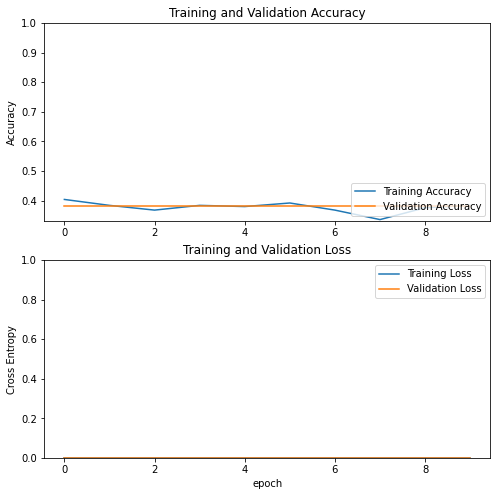

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [29]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [30]:
fine_tune_epochs = parameters["fine_tune_epochs"]
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callback_list,
                         validation_data=validation_dataset)


Epoch 10/20
8/8 [==============================] - 11s 663ms/step - loss: 1.0382e-07 - accuracy: 0.3659 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 11/20
Data successfully appendData successfully append

Data successfully append
Data successfully append
8/8 [==============================] - 7s 592ms/step - loss: 1.0233e-07 - accuracy: 0.3719 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 12/20
Data successfully append
Data successfully appendData successfully append

Data successfully append
8/8 [==============================] - 7s 611ms/step - loss: 9.8937e-08 - accuracy: 0.4059 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 13/20
Data successfully append
Data successfully appendData successfully append
Data successfully append

8/8 [==============================] - 8s 641ms/step - loss: 1.0171e-07 - accuracy: 0.3800 - val_loss: 1.0218e-07 - val_accuracy: 0.3810
Epoch 14/20
Data successfully append
Data successfully append
Data successfully append
Data successfull

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

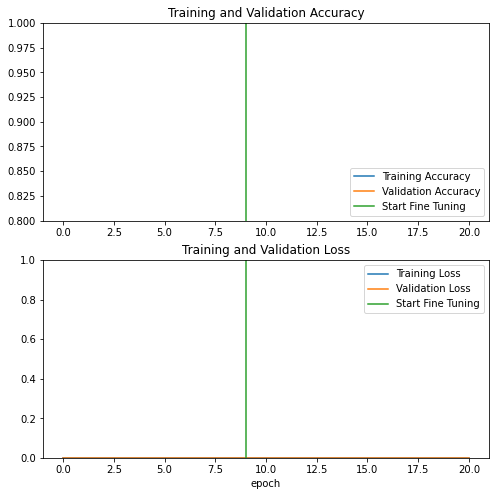

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# IF FINE_TUNE == TRUE (if you are using fine-tuned weights from a previous experiment for example)

In [ ]:
from tensorflow.keras import models

model = models.load_model(os.path.join(exp.base_dir, "model.h5"))
history_fine = model.fit(train_dataset,
                        epochs=parameters["fine_tune_epochs"],
                        initial_epoch=0,
                        callbacks=callback_list,
                        validation_data=validation_dataset)

### Store the weights (keras format and tensorflow format) 

Store every asset to Picsellia so you can perform inference and use if for further re-training

In [32]:
models_dir = os.path.join(exp.base_dir, 'models')
tf.saved_model.save(model, os.path.join(models_dir, 'saved_model'))
model.save(os.path.join(models_dir, 'keras_model/model.h5'))
exp.store("keras_model", os.path.join(models_dir, 'keras_model/model.h5'))
exp.store("model-latest", os.path.join(models_dir, 'saved_model'), zip=True)

INFO:tensorflow:Assets written to: classif/models/saved_model/assets
=========================                         ]

'e9f0b17e-cbe4-4fef-8190-115f4d89266a/0/saved_model.zip'

### Evaluation and predictions

And now you are all set to use this model to predict.

Predictions:
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Labels:
 [0 0 1 1 1 2 1 2 0 2 0 0 0 0 1 1 1 2 0 1 1 0 2 0 2 2 0 1 2 2 0 1]


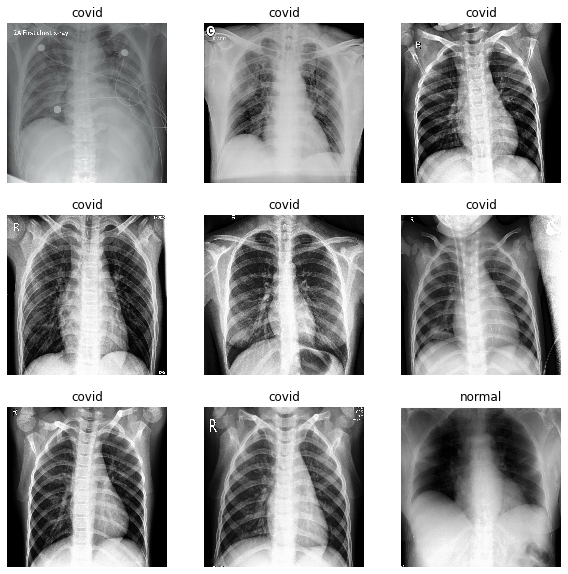

In [37]:
y_true = []
y_pred = []
for btc in range(len(validation_dataset)):
    image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    y_true.extend(label_batch)
    y_pred.extend(predictions.numpy())

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print('----------------')
print(confusion_matrix(y_true, y_pred))
print()
print('Classification Report')
print('---------------------')
print(classification_report(y_true, y_pred, target_names=exp.categories))
cm = {
    'categories': exp.categories,
    'values': confusion_matrix(y_true, y_pred).tolist()
}
exp.log('confusion-matrix', cm, 'heatmap')

Confusion Matrix
----------------
[[19  5  0]
 [22  0  0]
 [17  1  0]]

Classification Report
---------------------
              precision    recall  f1-score   support

       covid       0.33      0.79      0.46        24
      normal       0.00      0.00      0.00        22
   pneumonia       0.00      0.00      0.00        18

    accuracy                           0.30        64
   macro avg       0.11      0.26      0.15        64
weighted avg       0.12      0.30      0.17        64



/home/pn/.virtualenvs/picsellia/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, end the experiment by updating its status to success (if it has succeeded) and update the "fine_tune" parameter as the model saved can now only be used for fine-tuning as in the second part of the notebook.

In [39]:
parameters["fine_tune"] = True
exp.log("parameters", parameters, "table", replace=True)
exp.update(status="success")

{'base_experiment': None,
 'base_model': {'checkpoint_object_name': '',
  'description': 'This is a real game changer',
  'files': {'keras_model': '8a961129-4ac1-4dcf-bea9-1b63ca8bd9d0/model.h5'},
  'framework': 'tensorflow2',
  'model_id': '8a961129-4ac1-4dcf-bea9-1b63ca8bd9d0',
  'model_object_name': '',
  'network_name': 'mobilenet_v2_classif_160',
  'organization': {'name': 'pierre-nicolas'},
  'origin_checkpoint_objects': {},
  'owner': {'username': 'pierre-nicolas'},
  'private': False,
  'tag': ['classification'],
  'thumb_object_name': '',
  'type': 'classification'},
 'data': [{'date_created': '2021-09-29T10:36:08.694494Z',
   'id': 14224,
   'last_update': '2021-09-29T10:36:08.694136Z',
   'name': 'labelmap',
   'type': 'labelmap'},
  {'date_created': '2021-09-29T10:36:08.722205Z',
   'id': 14225,
   'last_update': '2021-09-29T10:36:08.721930Z',
   'name': 'parameters',
   'type': 'table'},
  {'date_created': '2021-09-29T10:41:16.195255Z',
   'id': 14226,
   'last_update': '2